# Data Cleaning and Analysis

In [2]:
import pandas as pd 

In [3]:
orders = pd.read_csv('../data/orders.csv')
order_products = pd.read_csv('../data/order_products__train.csv')
products = pd.read_csv('../data/products.csv')

orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [5]:
order_products.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [6]:
products.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [7]:
orders.duplicated().sum()

np.int64(0)

In [8]:
order_products.duplicated().sum()

np.int64(0)

In [9]:
products.duplicated().sum()

np.int64(0)

In [10]:
orders['order_id'].nunique()

3421083

In [11]:
order_products['product_id'].value_counts().head(10)

product_id
24852    18726
13176    15480
21137    10894
21903     9784
47626     8135
47766     7409
47209     7293
16797     6494
26209     6033
27966     5546
Name: count, dtype: int64

In [12]:
order_products = order_products.merge(products, on='product_id', how='left')
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
2,1,10246,3,0,Organic Celery Hearts,83,4
3,1,49683,4,0,Cucumber Kirby,83,4
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15


In [13]:
order_products.to_csv('../data/order_products_merged.csv', index=False)

In [14]:
# Count top products
top_products = (
    order_products['product_name']
    .value_counts()
    .head(50)  # take top 50 most common products
    .index
)

# Filter dataset
filtered_orders = order_products[order_products['product_name'].isin(top_products)]


In [15]:
top_order_ids = filtered_orders['order_id'].unique()[:10000]  # adjust number if needed
filtered_orders = filtered_orders[filtered_orders['order_id'].isin(top_order_ids)]

In [16]:
transactions = (
    filtered_orders
    .groupby('order_id')['product_name']
    .apply(list)
    .values
    .tolist()
)

# Check
transactions[:5]


[['Cucumber Kirby', 'Bag of Organic Bananas', 'Organic Hass Avocado'],
 ['Organic Half & Half', 'Organic Garnet Sweet Potato (Yam)', 'Asparagus'],
 ['Organic Baby Arugula'],
 ['Organic Cucumber',
  'Organic Grape Tomatoes',
  'Organic Raspberries',
  'Organic Blueberries'],
 ['Bag of Organic Bananas',
  'Organic Raspberries',
  'Organic Garlic',
  'Organic Italian Parsley Bunch',
  'Organic Yellow Onion',
  'Organic Zucchini']]

In [17]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket = pd.DataFrame(te_ary, columns=te.columns_)


# Association Rule Mining

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

In [19]:
# Set a minimum support (e.g., 0.01 means 1% of transactions)
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Sort to check
frequent_itemsets.sort_values(by='support', ascending=False).head()

,support,itemsets
2,0.2236,(Banana)
1,0.1896,(Bag of Organic Bananas)
37,0.1338,(Organic Strawberries)
16,0.1181,(Organic Baby Spinach)
10,0.0987,(Large Lemon)


In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sort by lift to see strongest
rules.sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
68,(Limes),(Organic Cilantro),0.0711,0.0431,0.0115,0.161744,3.752762,1.0,0.008436,1.141537,0.789675,0.111977,0.123988,0.214283
69,(Organic Cilantro),(Limes),0.0431,0.0711,0.0115,0.266821,3.752762,1.0,0.008436,1.266949,0.766569,0.111977,0.210702,0.214283
57,(Large Lemon),(Limes),0.0987,0.0711,0.0191,0.193516,2.721740,1.0,0.012082,1.151789,0.701862,0.126742,0.131786,0.231076
56,(Limes),(Large Lemon),0.0711,0.0987,0.0191,0.268636,2.721740,1.0,0.012082,1.232354,0.681008,0.126742,0.188545,0.231076
62,(Large Lemon),(Organic Red Onion),0.0987,0.0498,0.0106,0.107396,2.156549,1.0,0.005685,1.064526,0.595025,0.076867,0.060615,0.160124


In [21]:
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()

,antecedents,consequents,support,confidence,lift
0,(Bag of Organic Bananas),(Organic Baby Carrots),0.0101,0.053270,1.194396
1,(Organic Baby Carrots),(Bag of Organic Bananas),0.0101,0.226457,1.194396
2,(Bag of Organic Bananas),(Organic Baby Spinach),0.0277,0.146097,1.237062
3,(Organic Baby Spinach),(Bag of Organic Bananas),0.0277,0.234547,1.237062
4,(Bag of Organic Bananas),(Organic Blueberries),0.0144,0.075949,1.353821


# Visualizing the results

## Scatter Plot: support vs confidence

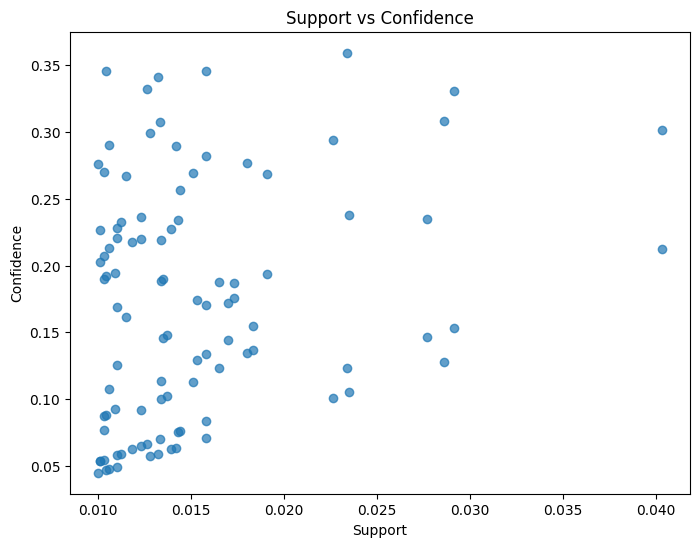

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.7)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence')
plt.show()

## Lift distribution plot

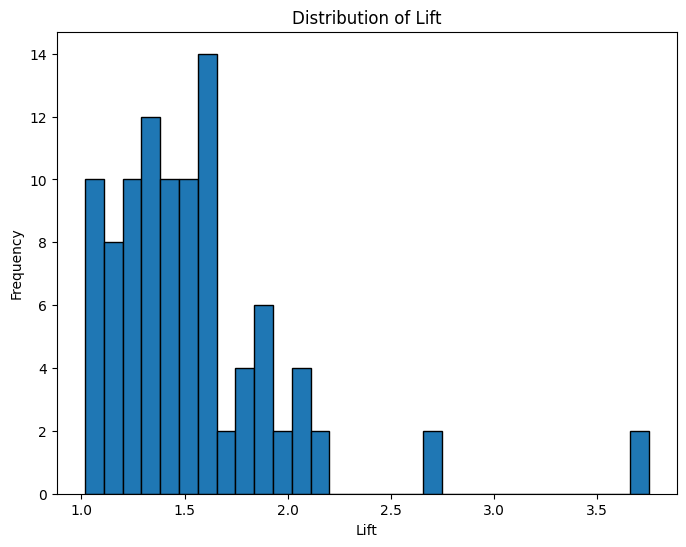

In [23]:
plt.figure(figsize=(8,6))
plt.hist(rules['lift'], bins=30, edgecolor='k')
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.title('Distribution of Lift')
plt.show()

## Creating readable rule labels

In [ ]:
rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents_str'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

## Top-cross sell opportunities

In [25]:
rules[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']]\
    .sort_values(by='lift', ascending=False).head(10)

,antecedents_str,consequents_str,support,confidence,lift
68,Limes,Organic Cilantro,0.0115,0.161744,3.752762
69,Organic Cilantro,Limes,0.0115,0.266821,3.752762
57,Large Lemon,Limes,0.0191,0.193516,2.721740
56,Limes,Large Lemon,0.0191,0.268636,2.721740
62,Large Lemon,Organic Red Onion,0.0106,0.107396,2.156549
63,Organic Red Onion,Large Lemon,0.0106,0.212851,2.156549
93,Organic Strawberries,Organic Raspberries,0.0180,0.134529,2.066500
92,Organic Raspberries,Organic Strawberries,0.0180,0.276498,2.066500
64,Limes,Organic Avocado,0.0135,0.189873,2.048257
65,Organic Avocado,Limes,0.0135,0.145631,2.048257
